In [1]:
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

## Functions

In [2]:
def normalize_col(column):
    return (column - column.min()) / (column.max()-column.min())

In [3]:
def df_basing(df:pd.DataFrame)->(pd.DataFrame,pd.DataFrame):
    base_df = df[test_tickers[0]].fillna(method='ffill')
    diff_df = df[test_tickers[1:]]
    for col in diff_df.columns:
        diff_df[col] = diff_df[col]/base_df
    diff_df=diff_df.apply(lambda x: x-1)
    return base_df, diff_df

In [4]:
def base_plot(tickers:list, diff_df):
    fig, ax = plt.subplots(1,1,figsize = (20,10))
    ax.axhline(0 ,color="r", label = tickers[0])
    ax.plot(diff_df,label=diff_df.columns)
    ax.set_title("Difference of European Traded Stocks Versus NYSE Traded Stock")
    ax.set_xlabel("Date")
    ax.set_ylabel(f"Percentage difference to {test_tickers[0]}")
    ax.legend()

In [5]:
def extract_trading_days(df):
    filled_df = df.fillna(method='ffill')
    return [group[1].between_time("14:30","16:30") for group in filled_df.groupby(filled_df.index.day)]

## Get Price Data

In [6]:
starts = pd.bdate_range('2012-01-01', '2022-12-31', freq="7B").to_frame(index=False)
stops = pd.bdate_range('2012-01-08', '2022-12-31', freq="7B").to_frame(index=False)
time_blocks = pd.concat([starts,stops], axis = 1)

display(time_blocks)

,0,0
0,2012-01-02,2012-01-09
1,2012-01-11,2012-01-18
2,2012-01-20,2012-01-27
3,2012-01-31,2012-02-07
4,2012-02-09,2012-02-16
...,...,...
405,2022-11-14,2022-11-21
406,2022-11-23,2022-11-30
407,2022-12-02,2022-12-09
408,2022-12-13,2022-12-20


In [7]:
test_tickers = ["RYAAY","RYA.IR","RY4C.DE"]

In [8]:
start = datetime(2023,1,11)
end = datetime(2023,1,18)
data = [yf.Ticker(ticker).history(interval='1m', start=start, end=end)["Close"] for ticker in test_tickers]
eur_usd = yf.Ticker('EUR=X').history(interval='1m', start=start, end=end)["Close"]

In [9]:
price_df = pd.concat(data, axis=1, ignore_index=False) #price data
price_df.columns = test_tickers
eur_usd=eur_usd.reindex(price_df.index).fillna(method='ffill')
price_df[test_tickers[1:]] = price_df[test_tickers[1:]].multiply(eur_usd.loc[price_df.index], axis=0)




return_df = pd.concat(data, axis=1, ignore_index=False) #price data
return_df.columns = test_tickers
for col in return_df.columns:
    return_df[col] = normalize_col(return_df[col])

## Visual Analysis

<AxesSubplot:xlabel='Datetime'>

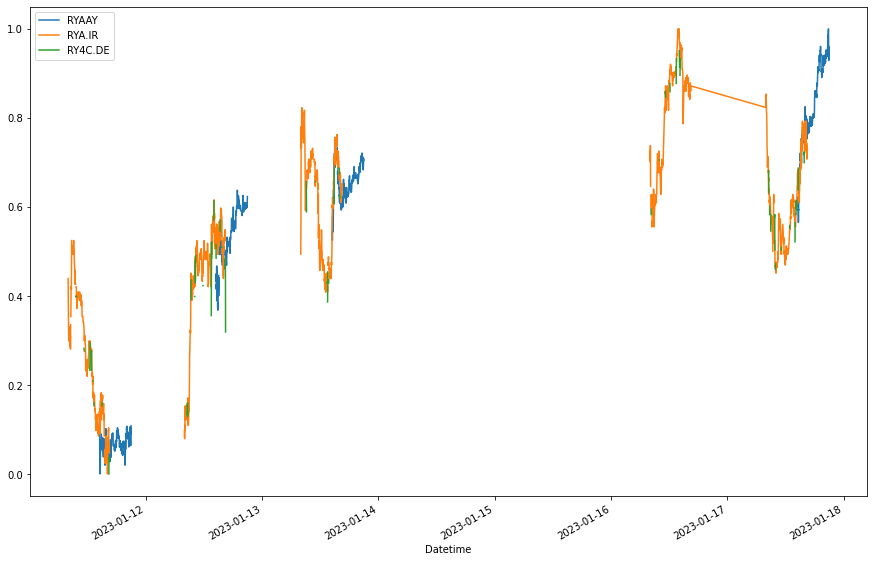

In [10]:
return_df.plot(figsize=(15,10))

In [11]:
base_df, diff_df = df_basing(return_df)

C:\Users\olive\AppData\Local\Temp\ipykernel_17104\3679318692.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df[col] = diff_df[col]/base_df


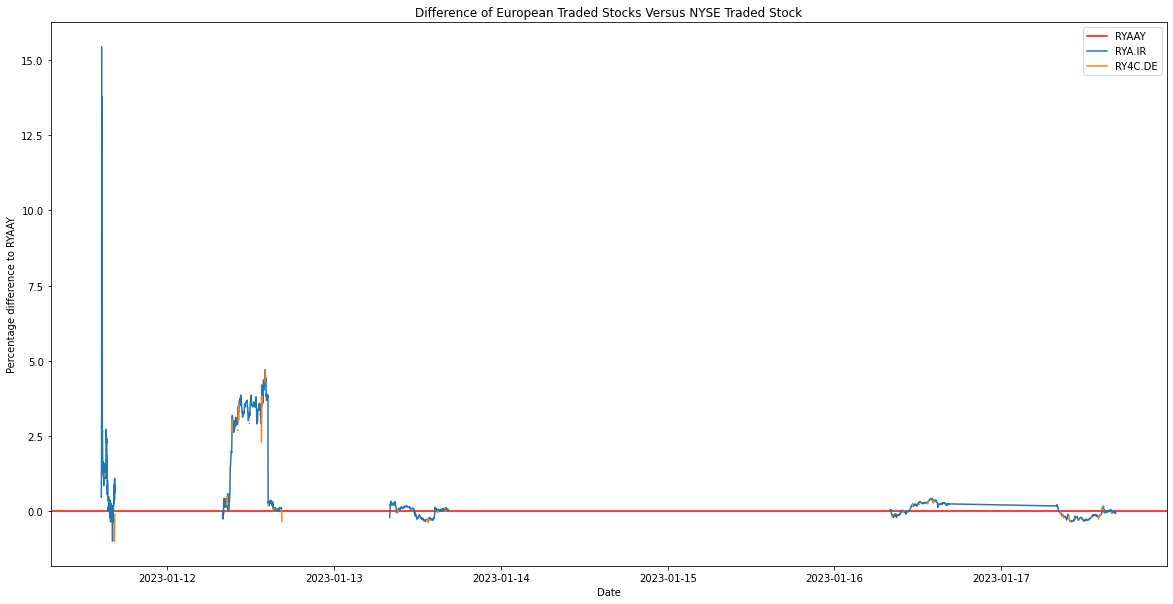

In [12]:
base_plot(test_tickers, diff_df)

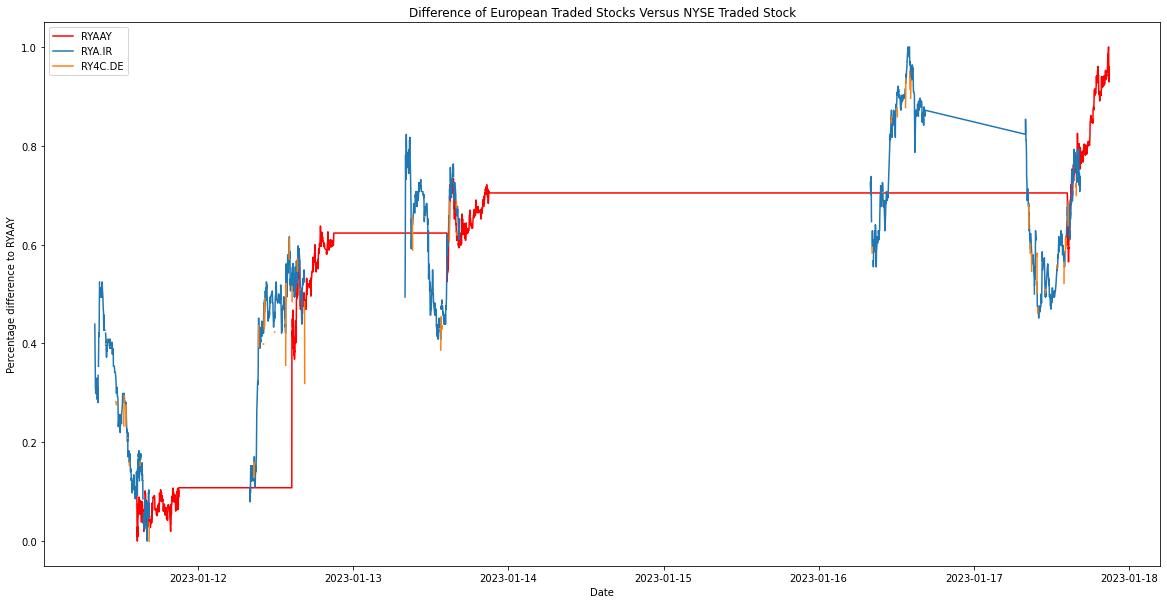

In [13]:
fig, ax = plt.subplots(1,1,figsize = (20,10))
ax.plot(base_df, label=base_df.name , color = "r")
ax.plot(return_df[test_tickers[-2:]],label=return_df[test_tickers[-2:]].columns)
ax.set_title("Difference of European Traded Stocks Versus NYSE Traded Stock")
ax.set_xlabel("Date")
ax.set_ylabel(f"Percentage difference to {test_tickers[0]}")
ax.legend()

## Trading Test

In [14]:
from IntradayRegionArbitrage import IntradayRegionArbitrage as IRA

In [46]:
trader = IRA(1000, 0.1, 0.03, 0.25, 0.01, True)

In [47]:
trading_days_returns = extract_trading_days(return_df)
trading_days_price = extract_trading_days(price_df)

In [48]:
bal = []
for td_return, td_price in zip(trading_days_returns,trading_days_price):
    base_df, diff_df = df_basing(td_return)
    for idx in diff_df.index:
        time_stamp = idx.time()
        price_data = td_price.loc[idx].values.flatten().tolist()
        return_data = diff_df.loc[idx].values.flatten().tolist()
        trader.data_feed(time_stamp, return_data, price_data, test_tickers)
        
        bal.append(trader.balance)
        

C:\Users\olive\AppData\Local\Temp\ipykernel_17104\3679318692.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df[col] = diff_df[col]/base_df
C:\Users\olive\AppData\Local\Temp\ipykernel_17104\3679318692.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_df[col] = diff_df[col]/base_df
C:\Users\olive\AppData\Local\Temp\ipykernel_17104\3679318692.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

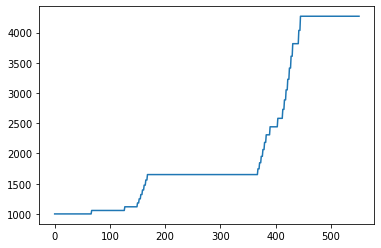

In [49]:
plt.plot(bal)

In [ ]:

print(trading_days_returns[0].loc[diff_df.index[0]].values.flatten().tolist())
print(trading_days_price[0].loc[diff_df.index[0]].values.flatten().tolist())
print(diff_df.loc[diff_df.index.time[0]].values.flatten().tolist())

## Trading